In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

<h2>Preprocessing </h2>

In [3]:
data = pd.concat([train, test])

Filling missing and nan value

In [4]:
data[['age_source1', 'age_source2']] = data[['age_source1', 'age_source2']].fillna(-99)
data[['province', 'district', 'maCv', 'FIELD_8']] = data[['province', 'district', 'maCv', 'FIELD_8']].fillna('Missing')
data[['FIELD_50', 'FIELD_51', 'FIELD_52', 'FIELD_53']] = data[['FIELD_50', 'FIELD_51', 'FIELD_52', 'FIELD_53']].fillna(-99.0)

In [5]:
dict_map = {'NaN': -1,
           'Zero': 0,
           'One':1,
           'Two':2,
           'Three':3,
           'Four':4}
data['FIELD_35'] = data['FIELD_35'].fillna('NaN').map(dict_map)

dict_map = {'NaN': -1,
           'I': 1,
           'II':2,
           'III':3,
           'IV':4,
           'V':4}
data['FIELD_41'] = data['FIELD_41'].fillna('NaN').map(dict_map)

dict_map = {'NaN': -1,
           'Zezo': 0,
           'One':1}
data['FIELD_42'] = data['FIELD_42'].fillna('NaN').map(dict_map)

dict_map = {'NaN': -1,
           'One':1,
           'Two':2}
data['FIELD_44'] = data['FIELD_44'].fillna('NaN').map(dict_map)

In [6]:
category_cols = [
    'FIELD_8', 'FIELD_9', 'FIELD_10','FIELD_13','FIELD_17','FIELD_24','FIELD_39', 'FIELD_43',
]
not_use_cols = ['id', 'label', 'maCv', 'province', 'district', 'FIELD_7']

<h2>Feature engineering </h2>

In [7]:
data['province'] = data['province'].apply(lambda x : str(x).lower())
data['district'] = data['district'].apply(lambda x : str(x).lower())
data['maCv'] = data['maCv'].apply(lambda x : str(x).lower())
data['is_province'] = data['province'].apply(lambda x : str(x).startswith('tỉnh')).astype('bool')
data['is_district'] = data['district'].apply(lambda x : str(x).startswith('huyện')).astype('bool')
data['len_FIELD_7'] = data['district'].apply(lambda x : len(list(x)))

In [8]:
# data['province'].apply(lambda x : str(x).startswith('tỉnh')).astype('bool')
data['FIELD_3_by_day'] = data['FIELD_3'] % 365

In [9]:
from pyvi import ViTokenizer as tokenizer
def tokenize(s):
    return tokenizer.tokenize(str(s)).lower()
train['maCv'] = train['maCv'].apply(lambda x: tokenize(x))

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer().fit(data['maCv'])
vec = vectorizer.transform(data['maCv'])
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=3, n_iter=7, random_state=42).fit(vec)
svd_vec = svd.transform(vec)
data['maCv_vec0'], data['maCv_vec1'], data['maCv_vec2'] = svd_vec[:, 0], svd_vec[:, 1], svd_vec[: , 2]


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
import ast
field_7_str = data['FIELD_7'].fillna('[]').astype(str).apply(lambda x: ' '.join(ast.literal_eval(x)))
vectorizer = TfidfVectorizer().fit(field_7_str)
vec = vectorizer.transform(field_7_str)
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=2, n_iter=7, random_state=42).fit(vec)
svd_vec = svd.transform(vec)
data['FILED_7_vec0'], data['FILED_7_vec1'] = svd_vec[:, 0], svd_vec[:, 1]

In [11]:
for col in category_cols + ['province', 'district', 'maCv']:
    field = dict(data[col].value_counts())
#     to_replace = []
#     for key, value in field.items():
#         if value < 2:
#             to_replace.append(key)
#     data[col] = data[col].replace(to_replace, 'UNKNOW')
    data[col+'_FREQ'] = data[col].map(field)

In [12]:
data['diff_age'] = abs(data['age_source1'] - data['age_source2'])


split

In [13]:
object_cols = [col for col in data.columns if data[col].dtype == 'object']
data[object_cols] = data[object_cols].astype('category')

In [14]:
train = data[data.label.notnull()]
test = data[data.label.isnull()]
test = test.drop(columns=['label'])
print(train.shape, test.shape)

(30000, 85) (20000, 84)


In [15]:
# add woe feature
train_woe = pd.read_csv('../input/woe_train.csv')
test_woe = pd.read_csv('../input/woe_test.csv')
# numberic_cols = ['new_FIELD_3','new_FIELD_50','FIELD_51','FIELD_52','FIELD_53', 'FIELD_54', 'FIELD_55', 'FIELD_56', 'FIELD_57']
train[train_woe.columns] = train_woe[train_woe.columns]
test[test_woe.columns] = test_woe[test_woe.columns]
print(train.shape, test.shape)

(30000, 143) (20000, 142)


In [16]:
train_cols = [col for col in train.columns if col not in not_use_cols]
train_X = train[train_cols]
train_y = train.label
print(train_X.shape, train_y.shape)

(30000, 137) (30000,)


In [17]:
train_y.value_counts()

0.0    29514
1.0      486
Name: label, dtype: int64

<h2>Hyperparams optimize </h2>

In [18]:
# from bayes_opt import BayesianOptimization

# fold__ = 5
# def LGB_CV(
#           max_depth,
#           num_leaves,
#           min_data_in_leaf,
#           feature_fraction,
#           bagging_fraction,
#           lambda_l1,
#           learning_rate
#          ):
#     num_round = 10000
#     kfold = 5
#     folds = StratifiedKFold(n_splits=kfold, shuffle=False, random_state=44000)
#     oof = np.zeros(len(train_X))

#     for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_X.values, train_y.values)):
#         print("fold n°{}".format(fold_))
#         param = {
#             'num_leaves': int(num_leaves),
#             'min_data_in_leaf': int(min_data_in_leaf), 
#             'objective':'binary',
#             'max_depth': int(max_depth),
#             'learning_rate': learning_rate,
#             "feature_fraction": feature_fraction,
#             "bagging_freq": 1,
#             "bagging_fraction": bagging_fraction ,
#             "bagging_seed": 11,
#             "metric": 'auc',
#             "lambda_l1": lambda_l1,
#             'n_estimators': 1500,
#             'boosting' : 'gbdt',
#             "verbosity": -1,
#             'seed':int(2**fold__),
#             'bagging_seed':int(2**fold__),
#             'drop_seed':int(2**fold__)
#         }
#         trn_data = lgb.Dataset(train_X.iloc[trn_idx][train_cols], label=train_y.iloc[trn_idx], categorical_feature=category_cols)
#         val_data = lgb.Dataset(train_X.iloc[val_idx][train_cols], label=train_y.iloc[val_idx], categorical_feature=category_cols)
#         clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds=500, categorical_feature=category_cols)
#         oof[val_idx] = clf.predict(train_X.iloc[val_idx][train_cols], num_iteration=clf.best_iteration)
        
# #         gc.collect()
        
#     return roc_auc_score(train_y, oof)
# LGB_BO = BayesianOptimization(LGB_CV, {
#     'max_depth': (4, 10),
#     'num_leaves': (5, 130),
#     'min_data_in_leaf': (10, 150),
#     'feature_fraction': (0.7, 1.0),
#     'bagging_fraction': (0.7, 1.0),
#     'lambda_l1': (0, 6),
#     'learning_rate':(0.005, 0.01)
# })

# LGB_BO.maximize(init_points=2, n_iter=30, acq='ei', xi=0.0)

In [19]:
# LGB_BO.max

<h2>Training model </h2>

In [20]:
num_round = 10000
kfold = 5
folds = StratifiedKFold(n_splits=kfold, shuffle=False, random_state=44000)
oof = np.zeros(len(train_X))
prediction = np.zeros(len(test))
score_arr = np.zeros(kfold)
feature_importance_df = pd.DataFrame()
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_X.values, train_y.values)):
    print("Fold {}".format(fold_))
    param = {'num_leaves': int(127.46944213018052),
            'min_data_in_leaf': int(142.8216562633925), 
            'objective':'binary',
            'max_depth': int(9.542177995080976),
            'learning_rate': 0.006001371601578423,
            "feature_fraction": 0.7106289550077538,
            "bagging_freq": 1,
            "bagging_fraction":  0.7896193631865245 ,
            "bagging_seed": 11,
            "metric": 'auc',
            "lambda_l1": 0.27253575066409175,
            'n_estimators': 1500,
            'boosting' : 'gbdt',
            "verbosity": -1,
            'seed':int(2**fold_),
            'bagging_seed':int(2**fold_),
            'drop_seed':int(2**fold_)}
    trn_data = lgb.Dataset(train_X.iloc[trn_idx][train_cols], label=train_y.iloc[trn_idx], categorical_feature=category_cols)
    val_data = lgb.Dataset(train_X.iloc[val_idx][train_cols], label=train_y.iloc[val_idx], categorical_feature=category_cols)
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds=500, categorical_feature=category_cols)
    oof[val_idx] = clf.predict(train_X.iloc[val_idx][train_cols], num_iteration=clf.best_iteration)
#     prediction += clf.predict(test[train_cols], num_iteration=clf.best_iteration)
    score_arr[fold_] = 2*roc_auc_score(train_y.iloc[val_idx], oof[val_idx]) - 1
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = train_cols
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    prediction += clf.predict(test[train_cols], num_iteration=clf.best_iteration) / folds.n_splits
print("CV score: {:<8.5f}".format(np.mean(score_arr)))

Fold 0
Training until validation scores don't improve for 500 rounds.
[100]	training's auc: 0.872504	valid_1's auc: 0.613513
[200]	training's auc: 0.900736	valid_1's auc: 0.614116
[300]	training's auc: 0.913509	valid_1's auc: 0.611444
[400]	training's auc: 0.922713	valid_1's auc: 0.606986
[500]	training's auc: 0.928318	valid_1's auc: 0.607472
Early stopping, best iteration is:
[15]	training's auc: 0.837466	valid_1's auc: 0.620576
Fold 1
Training until validation scores don't improve for 500 rounds.
[100]	training's auc: 0.880354	valid_1's auc: 0.577703
[200]	training's auc: 0.906757	valid_1's auc: 0.578417
[300]	training's auc: 0.920102	valid_1's auc: 0.574561
[400]	training's auc: 0.928738	valid_1's auc: 0.568681
[500]	training's auc: 0.932873	valid_1's auc: 0.567891
[600]	training's auc: 0.936798	valid_1's auc: 0.566056
Early stopping, best iteration is:
[130]	training's auc: 0.889841	valid_1's auc: 0.583877
Fold 2
Training until validation scores don't improve for 500 rounds.
[100]	

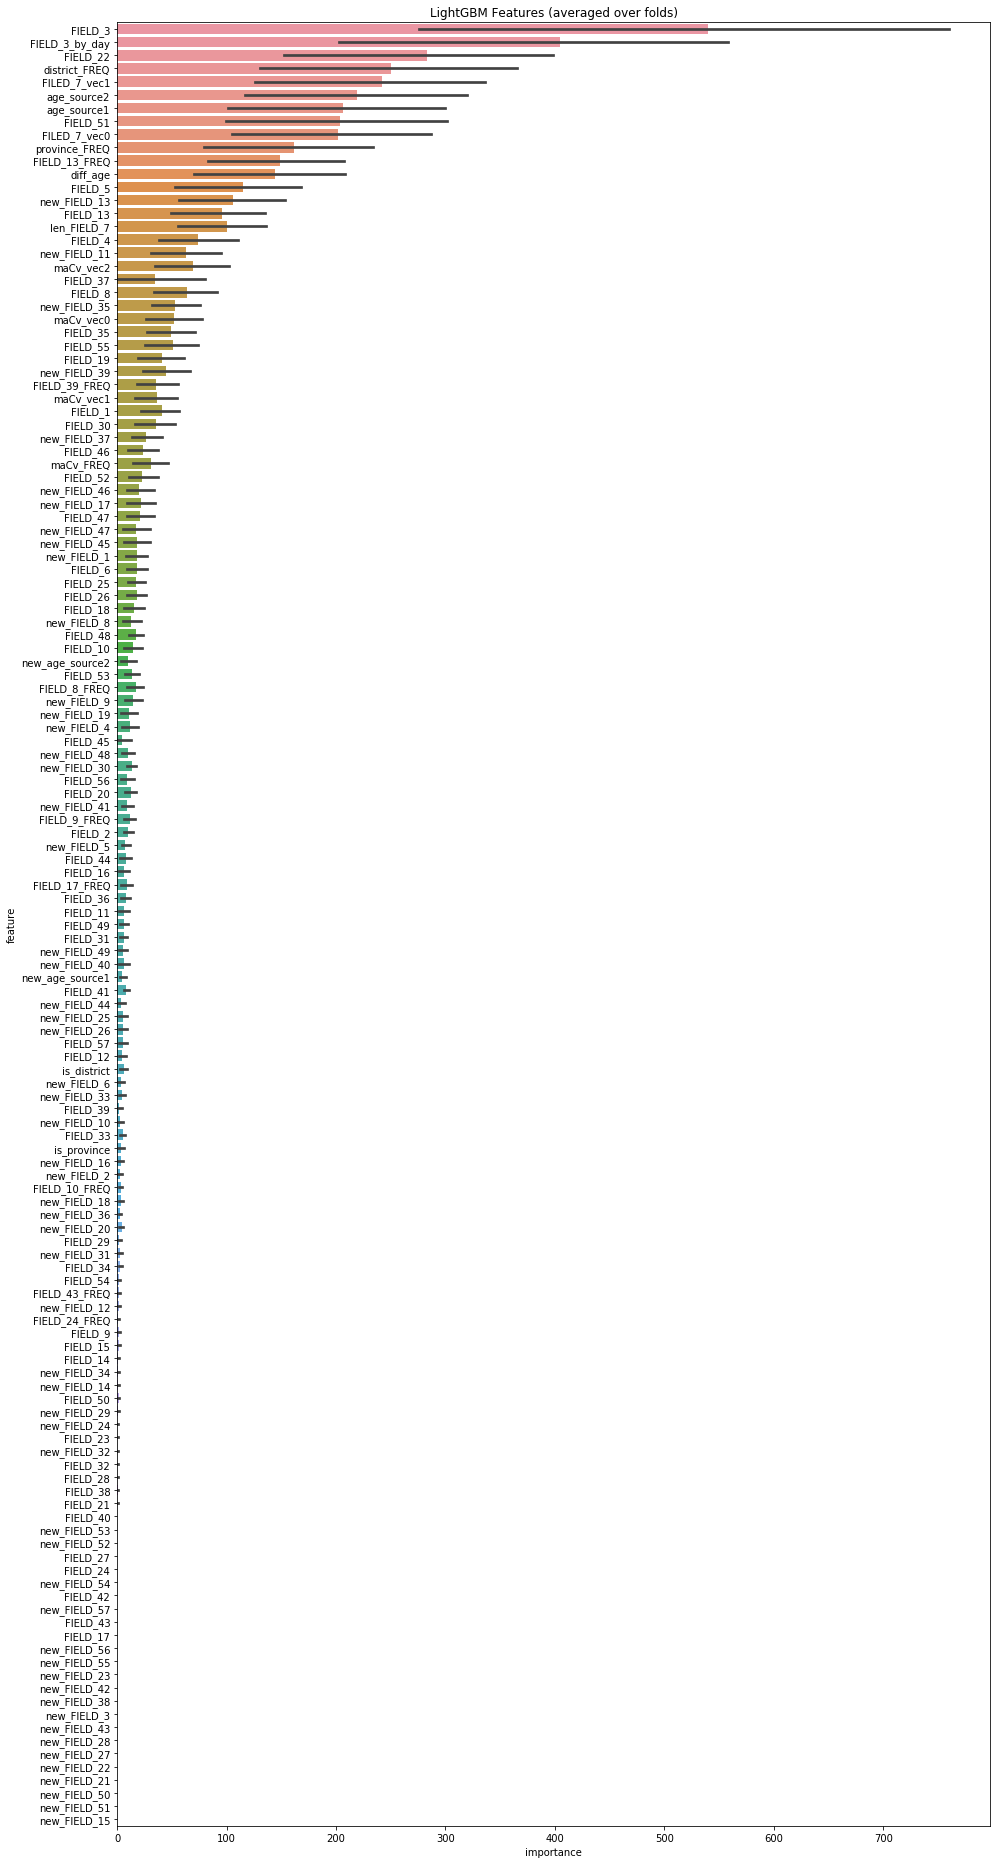

In [21]:

cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [22]:

submission = pd.read_csv('../input/sample_submission.csv')
submission['label'] = prediction
submission.to_csv('../input/submission.csv', index=False)